# Local spatial correlation between the social vulnerability of population and inundation risk of dam failure

This notebook demonstrates how the social vulnerability of the population (i.e., socially disadvantaged or non-disadvantaged) is spatially correlated with the inundation risk of a dam failure, focusing on a single dam. The analysis consists of the following two steps.
1. it identifies census blocks inundated from flooding caused by three dam failure scenarios with different water levels: normal high (NH), top of active storage (TAS), and maximum high (MH), retrived from the National Inventory of Dams (NID) of US Army Corps of Engineers. 
2. it employs two spatial correlation metrics (i.e., Bivariate Moran’s I and Bivariate Local Indicator of Spatial Association (LISA)) to investigate the relationship between the inundation risk and social vulnerability of the population per impacted locations from a single dam failure. In this context, we employed 16 census variables related to the social vulnerability index.

| Acronym | Note                            |
|---------|---------------------------------|
| POV150  | Below 150% Poverty              |
| UNEMP   | Unemployment Rate               |
| HBURD   | Housing Cost Burden             |
| NOHSDP  | No High School Diploma          |
| NOINSUR | No Health Insurance             |
| AGE65   | Aged 65 & Older                 |
| AGE17   | Aged 17 & Younger               |
| DISABL  | Civilian with a Disability      |
| SNGPNT  | Single-Parent Households        |
| LIMENG  | English Language Proficiency    |
| MINRTY  | Racial & Ethnic Minority Status |
| MUNIT   | Multi-Unit Structures           |
| MOBILE  | Mobile Homes                    |
| CROWD   | Crowding                        |
| NOVEH   | No Vehicle Household            |
| GROUPQ  | Group Quarters                  |


In [1]:
# Import necessary packages
import os
import pandas as pd
import geopandas as gpd
import subprocess
import json
import pygeos
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


import libpysal
import esda
import contextily as cx

## 0. Set up environment varialbes

In [2]:
# Working directory
data_dir = './data'
output_dir = os.getcwd()

# Find the list of dams 
fed_dams = pd.read_csv('./data/dam_list.csv')
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
print(f'Total count of dams available for local analysis: {fed_dams.shape[0]}')

# Dam of Interest
dam_id = 'CA10022' # example dam for demonstrating local analysis
API_Key = 'ENTER CENSUS API KEY HERE' # The API key can be obtained through https://api.census.gov/data/key_signup.html

print(f'Dam of Interest: {dam_id}')

Total count of dams available for local analysis: 345
Dam of Interest: CA10022


## 1. Find census blocks impacted by three dam failure scenarios

Spatial intersections are conducted to find the submerged census blocks from three dam failure scenarios (i.e., breach of dam structure with the water level of normal high (NH), top of active storage (TAS), and maximum high (MH)). <br> Per each scenario, <br>
1. we vectorized the original raster into a polygon and spatially queried census blocks using Boolean logic. In other words, a census block has a value of one if it intersects with the inundation polygon; otherwise, it has zero. 
2. we overlaid three polygons from three dam breach scenarios (i.e., MH, TAS, and NH) to estimate the potential risk of flooding. <br>
3. we found census blocks that intersected with the polygonized geometry and then kept the highest inundation risk value (i.e., 1~3) per census block. 

As a result, the inundation risk of a single dam failure provides polygons with values ranging from one through three.  A census block with a value of three means the location will be submerged for every scenario (NH, TAS, and MH), whereas a polygon having a value of one means that the area would only get impacted for the worst-case scenario (MH breach).

### 1.1. Vectorize inundations of three scenarios and overlaid them

Creating output file that is 197P x 137L.
Processing ./data/NID_FIM_MH_F/MH_F_CA10022.tiff [1/1] : 0Using internal nodata values (e.g. 0) for image ./data/NID_FIM_MH_F/MH_F_CA10022.tiff.
Copying nodata values from source ./data/NID_FIM_MH_F/MH_F_CA10022.tiff to destination /afs/crc.nd.edu/user/m/mislam5/floability-project/floability-cli/example/iguide-gis-aging-dams/workflow/MH_F_CA10022_resample.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
--outfile=/afs/crc.nd.edu/user/m/mislam5/floability-project/floability-cli/example/iguide-gis-aging-dams/workflow/MH_F_CA10022_reclass.tiff
0...10...20...30...40...50...60...70...80...90...Several drivers matching json extension. Using GeoJSON
Creating output /afs/crc.nd.edu/user/m/mislam5/floability-project/floability-cli/example/iguide-gis-aging-dams/workflow/MH_F_CA10022.json of format GeoJSON.
100 - done.
Creating output file that is 190P x 129L.
Processing ./data/NID_FIM_TAS_F/TAS_F_CA10022.tiff [1/1] : 0Using internal noda

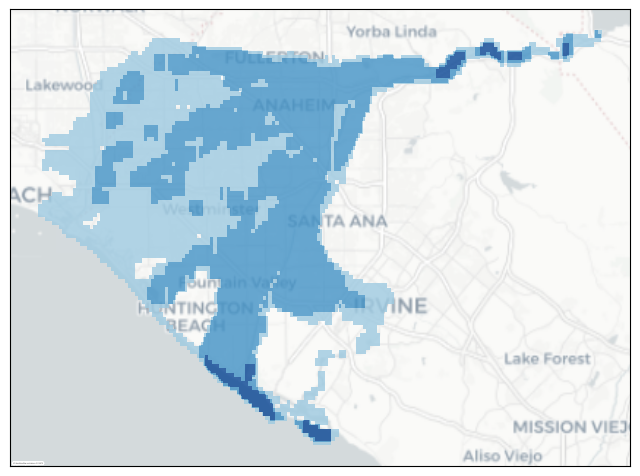

In [3]:
def resample_raster(rasterfile_path, filename, target_path, rescale_factor):
    # first determine pixel size for resampling
    xres = 0
    yres = 0
    
    out = subprocess.run(["gdalinfo","-json",rasterfile_path],stdout=subprocess.PIPE)
    raster_meta = json.loads(out.stdout.decode('utf-8'))
    if 'geoTransform' in raster_meta:
        xres = raster_meta['geoTransform'][1]
        yres = raster_meta['geoTransform'][5]
        xres = xres * rescale_factor
        yres = yres * rescale_factor

    if (xres != 0) and (yres != 0):
        # resample raster
        save_path = target_path +"/"+ filename + f"_resample.tiff"
        subprocess.run(["gdalwarp","-r","bilinear","-of","GTiff","-tr",str(xres),str(yres),rasterfile_path,save_path])

        return save_path, raster_meta

def polygonize_fim(rasterfile_path, target_path):

    # Extract target path and filename from the given raster file path
    # target_path = '/'.join(rasterfile_path.split('/')[:-1])
    filename = rasterfile_path.split("/")[-1].split(".")[-2]

    # Define paths
    resample_path = target_path +"/"+ filename + f"_resample.tiff"
    reclass_file = target_path + "/" + filename + "_reclass.tiff"
    geojson_out = "%s/%s.json" % (target_path, filename)

    for temp_path_ in [resample_path, reclass_file, geojson_out]:
        if os.path.exists(temp_path_):
            os.remove(temp_path_)

    # Resample raster file to 10-times smaller
    resample_path, raster_meta = resample_raster(rasterfile_path, filename, target_path, rescale_factor=4)

    # Reclassify raster
    outfile = "--outfile="+reclass_file
    print(outfile)
    no_data_val = raster_meta['bands'][0]['noDataValue']
    # subprocess.run(["gdal_calc.py","-A",resample_path,outfile,f"--calc=1*(A>0)",f"--NoDataValue={no_data_val}"],stdout=subprocess.PIPE)
    subprocess.run(["gdal_calc.py","-A",resample_path,outfile,f"--calc=-9999*(A<=0)+1*(A>0)",f"--NoDataValue={no_data_val}"],stdout=subprocess.PIPE)
        
    # Polygonize the reclassified raster
    subprocess.run(["gdal_polygonize.py", reclass_file, "-b", "1", geojson_out, filename, "value"])

    inund_polygons = gpd.read_file(geojson_out)

    # If GeoDataFrame has records
    if inund_polygons.shape[0] != 0:
        inund_polygons = inund_polygons.loc[(inund_polygons['value'] != -9999) & (inund_polygons['value'] != 0)]  # Remove pixels of null value

        # drop invalid geometries
        inund_polygons = inund_polygons.loc[inund_polygons['geometry'].is_valid, :]

        # Coverage for each class of inundation map
        inund_per_cls = inund_polygons.dissolve(by='value')
        inund_per_cls.reset_index(inplace=True)

        # remove all temp files
        os.remove(resample_path)
        os.remove(reclass_file)
        os.remove(geojson_out)

        # inundation_per_cls: GeoDataFrame 
        return inund_per_cls

    else:
        return gpd.GeoDataFrame(data={'value': 1}, index=[0], geometry=[None])
    
    
def fim_multiple_scenarios(dam_id, input_dir, output_dir):
    
    sce_mh = {'loadCondition': 'MH', 'breachCondition': 'F'}  # Maximun Height scenario
    sce_tas = {'loadCondition': 'TAS', 'breachCondition': 'F'}  # Top of Active Storage scenario
    sce_nh = {'loadCondition': 'NH', 'breachCondition': 'F'}  # Normal Height scenario

    # Maximun Height scenario (weight: 1)
    fim_path_mh = f"{input_dir}/NID_FIM_{sce_mh['loadCondition']}_{sce_mh['breachCondition']}/{sce_mh['loadCondition']}_{sce_mh['breachCondition']}_{dam_id}.tiff"
    fim_gdf_mh = polygonize_fim(fim_path_mh, output_dir)
    fim_gdf_mh['value_mh'] = fim_gdf_mh['value'] * 1
    fim_gdf_mh.drop(columns=['value'], inplace=True)

    # Top of Active Storage scenario (weight: 1)
    fim_path_tas = f"{input_dir}/NID_FIM_{sce_tas['loadCondition']}_{sce_tas['breachCondition']}/{sce_tas['loadCondition']}_{sce_tas['breachCondition']}_{dam_id}.tiff"
    fim_gdf_tas = polygonize_fim(fim_path_tas, output_dir)
    fim_gdf_tas['value_tas'] = fim_gdf_tas['value'] * 1
    fim_gdf_tas.drop(columns=['value'], inplace=True)

    # Normal Height scenario (weight: 1)
    fim_path_nh = f"{input_dir}/NID_FIM_{sce_nh['loadCondition']}_{sce_nh['breachCondition']}/{sce_nh['loadCondition']}_{sce_nh['breachCondition']}_{dam_id}.tiff"
    fim_gdf_nh = polygonize_fim(fim_path_nh, output_dir)
    fim_gdf_nh['value_nh'] = fim_gdf_nh['value'] * 1
    fim_gdf_nh.drop(columns=['value'], inplace=True)

    # Find intersections of inundated area across multiple scenarios
    temp_fim_gdf = gpd.overlay(fim_gdf_nh, fim_gdf_tas, how='union')
    fim_gdf = gpd.overlay(temp_fim_gdf, fim_gdf_mh, how='union')
    fim_gdf.fillna(0, inplace=True)

    # Sum values (1: MH only, 2: MH + TAS , 3: MH + TAS + NH)
    fim_gdf['value'] = fim_gdf.apply(lambda x:x['value_mh'] + x['value_tas'] + x['value_nh'], axis=1)
    fim_gdf.drop(columns=['value_mh', 'value_tas', 'value_nh'], inplace=True)
    fim_gdf['Dam_ID'] = dam_id
        
    return fim_gdf



fim_gdf = fim_multiple_scenarios(dam_id, data_dir, output_dir)

# Plot polygonized inundation risk of a dam failure
color_brewer = ['#9ecae1','#4292c6','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)

fig, ax = plt.subplots(figsize=(8,8))
fim_gdf.plot('value', ax=ax, cmap=cm, alpha=0.8)
# cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=fim_gdf.crs, attribution_size=0, zoom=10) # Add basemap ## this gives error,
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=fim_gdf.crs, attribution_size=0, zoom=10) # Another provider for source fixes the error

# Hide coordinates in the plot axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### 1.2. Calculate the highest inundation risk value per census block

In [4]:
# This function returns the id of states that would be impacted by the failure of the dam of interest
def state_num_related_to_fim(fim_gdf, tract_gdf):
    
    tract_geoms = pygeos.from_shapely(tract_gdf['geometry'].values)
    tract_geoms_tree = pygeos.STRtree(tract_geoms, leafsize=50)

    fim_geom_union = pygeos.from_shapely(fim_gdf['geometry'].unary_union)    
    query_intersect = tract_geoms_tree.query(fim_geom_union, predicate='intersects')
    tract_gdf = tract_gdf.loc[query_intersect]

    tract_gdf['STATE'] = tract_gdf.apply(lambda x:x['GEOID'][0:2], axis=1)
    unique_state = tract_gdf['STATE'].unique()
    
    # return type: list
    return unique_state

# Census tract geometry across the conterminous United States
tract_gdf = gpd.read_file(os.path.join(data_dir, 'census_geometry', 'census_tract_from_api.geojson'))
fim_state = state_num_related_to_fim(fim_gdf, tract_gdf)

# Load census block geometry of the selected states
if len(fim_state) == 1: # If only one state is associated with the inundation mapping
    block_gdf = gpd.read_file(os.path.join(data_dir, 'census_geometry', f'tl_2020_{fim_state[0]}_tabblock20.geojson'))
elif len(fim_state) >= 2: # If multiple states are associated with the inundation mapping
    block_gdf = pd.DataFrame()
    for state_num in fim_state:
        temp_gdf = gpd.read_file(os.path.join(data_dir, 'census_geometry', f'tl_2020_{state_num}_tabblock20.geojson'))
        block_gdf = pd.concat([temp_gdf, block_gdf]).reset_index(drop=True)
    block_gdf = gpd.GeoDataFrame(block_gdf, geometry=block_gdf['geometry'], crs="EPSG:4326")
else:
    raise AttributeError('NO STATE is related to Inundation Mapping')

# Destination dataframe to save the results
fim_geoid_gdf = gpd.GeoDataFrame({'Dam_ID': pd.Series(dtype='str'),
                                  'GEOID': pd.Series(dtype='str'),
                                  'Class': pd.Series(dtype='str')
                                 }
                            )    

# Create STRtree for block_gdf
block_geoms = pygeos.from_shapely(block_gdf['geometry'].values)
block_geoms_tree = pygeos.STRtree(block_geoms, leafsize=50)

# Extract census tract intersecting with each class of inundation map
for water_cls in fim_gdf['value'].unique():
    fim_geom_ = pygeos.from_shapely(fim_gdf.loc[fim_gdf['value'] == water_cls, 'geometry'].unary_union)
    query_fim_geom_ = block_geoms_tree.query(fim_geom_, predicate='intersects')
    fim_geoid_ = block_gdf.loc[query_fim_geom_]
    fim_geoid_['Class'] = water_cls
    fim_geoid_['Dam_ID'] = dam_id
    
    fim_geoid_gdf = pd.concat([fim_geoid_, fim_geoid_gdf]).reset_index(drop=True)

# Cleaning output
fim_geoid_gdf = fim_geoid_gdf[['GEOID', 'Dam_ID', 'Class', 'geometry']]

# Find the highest inundation risk per census block
fim_geoid_gdf = fim_geoid_gdf.groupby(['Dam_ID', 'GEOID'], 
                                group_keys=False).apply(lambda x:x.loc[x['Class'].idxmax()]
                                                        ).reset_index(drop=True)
fim_geoid_gdf = fim_geoid_gdf.set_crs(epsg=4326)
fim_geoid_gdf

/tmp/ipykernel_720216/3980726591.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fim_geom_union = pygeos.from_shapely(fim_gdf['geometry'].unary_union)
/tmp/ipykernel_720216/3980726591.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fim_geom_ = pygeos.from_shapely(fim_gdf.loc[fim_gdf['value'] == water_cls, 'geometry'].unary_union)
/tmp/ipykernel_720216/3980726591.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fim_geoid_gdf = pd.concat([fim_geoid_, fim_geoid_gdf]).reset_index(drop=True)
/tmp/ipykernel_720216/3980726591.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method

,GEOID,Dam_ID,Class,geometry
0,060375039024005,CA10022,1.0,"POLYGON ((-118.02026 33.88799, -118.01772 33.8..."
1,060375039024007,CA10022,1.0,"POLYGON ((-118.01348 33.8867, -118.01344 33.88..."
2,060375039024008,CA10022,1.0,"POLYGON ((-118.02151 33.88053, -118.02147 33.8..."
3,060375039024009,CA10022,1.0,"POLYGON ((-118.02383 33.88528, -118.02376 33.8..."
4,060375039024012,CA10022,1.0,"POLYGON ((-118.02897 33.88792, -118.02887 33.8..."
...,...,...,...,...
12885,060710001213019,CA10022,1.0,"POLYGON ((-117.67423 33.88883, -117.67421 33.8..."
12886,060710001221013,CA10022,3.0,"POLYGON ((-117.72402 33.90629, -117.72401 33.9..."
12887,060710001221014,CA10022,2.0,"POLYGON ((-117.67604 33.888, -117.67586 33.888..."
12888,060710001221015,CA10022,2.0,"POLYGON ((-117.67551 33.87397, -117.67529 33.8..."


### 1.3. Step 1 results (Inundation risk per census block)

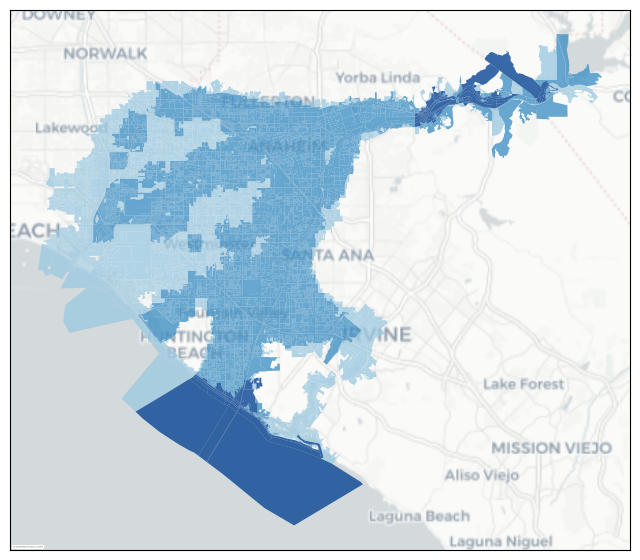

In [5]:
# Plot census block with inundation risk of a dam failure
color_brewer = ['#9ecae1','#4292c6','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)

fig, ax = plt.subplots(figsize=(8,8))
fim_geoid_gdf.plot('Class', ax=ax, cmap=cm, alpha=0.8)
# cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=fim_gdf.crs, attribution_size=0, zoom=10)
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=fim_gdf.crs, attribution_size=0, zoom=10) # Another provider for source fixes the error

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

## 2. Retrive Census Data

To investigate the social vulnerability of the population at-risk of dam failure, we retrieve the following variables from Census API.

![](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI-Variables.png?_=02699)

Source: https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2020.html

In [6]:
def call_census_table(state_list, table_name, key):
    
    result_df = pd.DataFrame()
    
    # querying at census tract level
    for state in state_list:
        if table_name.startswith('DP'):
            address = f'https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        elif table_name.startswith('S'):
            address = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        elif table_name.startswith('B'):
            address = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,{table_name}&for=tract:*&in=state:{state}&in=county:*'
        else:
            raise AttributeError('Proper Table Name Is Needed.')
            
        response = requests.get(f'{address}&key={key}').json()
        result_ = pd.DataFrame(response)
        
        result_.columns = response[0]
        result_.drop(0, axis=0, inplace=True)
        
        result_df = pd.concat([result_, result_df]).reset_index(drop=True)
        
    # result_df = result_df.rename(columns={'GEO_ID':'GEOID_T'})
    result_df['GEOID_T'] = result_df.apply(lambda x: x['state'] + x['county'] + x['tract'], axis=1)
    result_df[table_name] = result_df[table_name].astype(float)
        
    return result_df[['GEOID_T', table_name]]


# Employed census tables to calculate each social vulnerabilty related variables.
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
    "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
    "EP_UNEMP"  : 'DP03_0009PE',
    "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                   'S2503_C01_001E'],
    "EP_NOHSDP" : 'S0601_C01_033E',
    "EP_UNINSUR" : 'S2701_C05_001E',
    "EP_AGE65" : 'S0101_C02_030E',
    "EP_AGE17" : [['B09001_001E'], 
                  'S0601_C01_001E'],
    "EP_DISABL" : 'DP02_0072PE',
    "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
    "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                    'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                    'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                   'B16005_001E'],
    "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                    'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                   'S0601_C01_001E'],
    "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                  'DP04_0001E'],
    "EP_MOBILE" : 'DP04_0014PE',
    "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                  'DP04_0002E'],
    "EP_NOVEH" : 'DP04_0058PE',
    "EP_GROUPQ": [['B26001_001E'], 
                  'S0601_C01_001E']
}


# Calculate GEOID for census tract as the census data is provided based on census tract
fim_geoid_gdf['GEOID_T'] = fim_geoid_gdf.apply(lambda x:x['GEOID'][0:11], axis=1)

# List of states that is associated with the dam failure
state_list = fim_geoid_gdf.apply(lambda x:x['GEOID'][0:2], axis=1).unique()

cols = list(census_info.keys())
cols.append('GEOID_T')

'''
This commented cell demonstrates how the census data was retrieved from the Census API.
To avoid potential issue during the API calling, this demonstration loads `census_data.csv`,
which is already retrieved and stored in the repo. 

attr_df = pd.DataFrame({'GEOID_T':fim_geoid_gdf['GEOID_T'].unique().tolist()})
for attr in census_info.keys(): # attr: svi-related census abbriviation on the final table
    print(f'Retrieving {attr} from Census API')
    
    if type(census_info[attr]) == str:
        temp_table = call_census_table(state_list, census_info[attr], API_Key)
        attr_df = attr_df.merge(temp_table, on='GEOID_T')
        attr_df = attr_df.rename(columns={census_info[attr]: attr})
    else:
        for table in census_info[attr][0]: # Retrieve numerator variables
            temp_table = call_census_table(state_list, table, API_Key)
            attr_df = attr_df.merge(temp_table, on='GEOID_T')

        temp_table = call_census_table(state_list, census_info[attr][1], API_Key) # Retrieve denominator variable
        attr_df = attr_df.merge(temp_table, on='GEOID_T')

        # Calculate the ratio of each variable
        attr_df[attr] = attr_df[census_info[attr][0]].sum(axis=1) / attr_df[census_info[attr][1]] * 100

    # Remove intermediate columns used for SVI related census calculation
    attr_df = attr_df[attr_df.columns.intersection(cols)]

    # Replace not valid value (e.g., -666666) from census with nan value
    attr_df[attr] = attr_df.apply(lambda x: float('nan') if x[attr] < 0 else x[attr], axis=1)
'''

# Merge census data with fim_geoid_gdf
attr_df = pd.read_csv(os.path.join(data_dir, 'census_geometry', 'census_data.csv')) 
attr_df['GEOID_T'] = attr_df['GEOID_T'].astype(str)
attr_df['GEOID_T'] = attr_df.apply(lambda x:x['GEOID_T'].zfill(11), axis=1)
fim_geoid_gdf = fim_geoid_gdf.merge(attr_df, on='GEOID_T')

# Reproject fim_geoid to EPSG:5070, NAD83 / Conus Albers (meters)
fim_geoid_gdf = fim_geoid_gdf.to_crs(epsg=5070)
fim_geoid_gdf.head(3)


,GEOID,Dam_ID,Class,geometry,GEOID_T,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,...,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
0,060375039024005,CA10022,1.0,"POLYGON ((-2003977.735 1435675.809, -2003750.2...",06037503902,6.510178,4.0,15.435795,11.3,0.4,...,25.077853,8.5,2.927478,3.541545,65.140136,1.463739,0.0,5.322688,1.5,0.10991
1,060375039024007,CA10022,1.0,"POLYGON ((-2003405.139 1435392.279, -2003400.1...",06037503902,6.510178,4.0,15.435795,11.3,0.4,...,25.077853,8.5,2.927478,3.541545,65.140136,1.463739,0.0,5.322688,1.5,0.10991
2,060375039024008,CA10022,1.0,"POLYGON ((-2004280.416 1434890.86, -2004274.01...",06037503902,6.510178,4.0,15.435795,11.3,0.4,...,25.077853,8.5,2.927478,3.541545,65.140136,1.463739,0.0,5.322688,1.5,0.10991


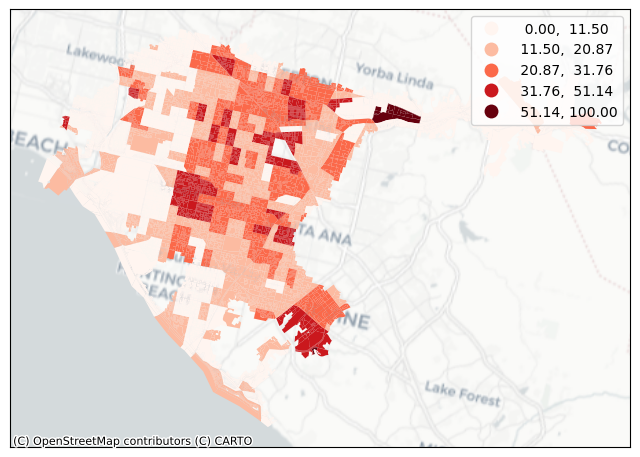

In [7]:
## Plot an example of census variable (POV150: Below 150% Poverty)

fig, ax = plt.subplots(figsize=(8,8))

fim_geoid_gdf.plot('EP_POV150', ax=ax, scheme='naturalbreaks', cmap='Reds', legend=True)
# cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=fim_geoid_gdf.crs, attribution_size=0, zoom=10)
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=fim_geoid_gdf.crs, zoom=10)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

## 3. Relationship between social vulnerabilty of population and inundation risk of dam failure

Based on two well-known metrics (Bivariate Moran’s I and Bivariate Local Indicator of Spatial Association (LISA)) spatial correlation step investigates the relationship between the inundation risk and social vulnerability of each census variable at the census block level. Each metric takes two input variables: 1) the potential risk of dam failure-induced flooding and 2) one out of 16 census data related to social vulnerability. Here, we employed the Queen’s case as spatial contiguity for calculating the Bivariate Moran’s I and LISA.

In [8]:
def calculate_bivariate_Moran_I_and_LISA(dam_id, census_dic, fim_geoid_gdf, dams_gdf):

    input_cols = list(census_dic.keys())
    input_cols.extend(['Dam_ID', 'GEOID', 'Class', 'geometry'])
    fim_geoid_local = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id, input_cols].reset_index(drop=True)
    dam_local = dams_gdf.loc[dams_gdf['ID'] == dam_id].reset_index(drop=True)

    # Iterate through all census variables
    for census_name in census_dic.keys():
        new_col_name = census_name.split("_")[1]
        
        # Remove invalid values of census data for local fim_geoid 
        fim_geoid_local_var = fim_geoid_local.loc[(~fim_geoid_local[census_name].isna()) & (fim_geoid_local[census_name] >= 0), 
        ['Dam_ID', 'GEOID', 'Class', census_name, 'geometry']].reset_index(drop=True)
        
        # Calculate Bivaraite Moran's I & Local Moran's I with Queen's Case Contiguity
        w = libpysal.weights.Queen.from_dataframe(fim_geoid_local_var)  # Adjacency matrix (Queen case)
        bv_mi = esda.Moran_BV(fim_geoid_local_var['Class'], fim_geoid_local_var[census_name], w)          
        bv_lm = esda.Moran_Local_BV(fim_geoid_local_var['Class'], fim_geoid_local_var[census_name], w, seed=17)

        # Enter results of Bivariate LISA into each census region
        lm_dict = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
        for idx in range(fim_geoid_local_var.shape[0]):
            if bv_lm.p_sim[idx] < 0.05:
                fim_geoid_local_var.loc[idx, f'LISA_{new_col_name}'] = lm_dict[bv_lm.q[idx]]
            else:
                fim_geoid_local_var.loc[idx, f'LISA_{new_col_name}'] = 'Not_Sig'

        fim_geoid_local_na = fim_geoid_local.loc[fim_geoid_local[census_name].isna(), ['Dam_ID', 'GEOID', 'Class', census_name, 'geometry']]
        fim_geoid_local_na[f'LISA_{new_col_name}'] = 'NA'
        fim_geoid_local_var = pd.concat([fim_geoid_local_var, fim_geoid_local_na]).reset_index(drop=True)       
        fim_geoid_local = fim_geoid_local.merge(fim_geoid_local_var[['GEOID', f'LISA_{new_col_name}']], on='GEOID')

        # Enter Bivariate Moran's I result into each dam
        dam_local[f'MI_{new_col_name}'] = bv_mi.I
        dam_local[f'pval_{new_col_name}'] = bv_mi.p_z_sim
        
    return dam_local, fim_geoid_local

# Calculates Bivariate Moran's I (mi) and Bivariate LISA (lm)
mi, lm = calculate_bivariate_Moran_I_and_LISA(dam_id, census_info, fim_geoid_gdf, fed_dams)
lm.head(3)

/tmp/ipykernel_720216/2393134987.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(fim_geoid_local_var)  # Adjacency matrix (Queen case)
/tmp/ipykernel_720216/2393134987.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(fim_geoid_local_var)  # Adjacency matrix (Queen case)
/tmp/ipykernel_720216/2393134987.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(fim_geoid_local_var)  # Adjacency matrix (Queen case)
/tmp/ipykernel_720216/2393134987.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. 

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,...,LISA_AGE17,LISA_DISABL,LISA_SNGPNT,LISA_LIMENG,LISA_MINRTY,LISA_MUNIT,LISA_MOBILE,LISA_CROWD,LISA_NOVEH,LISA_GROUPQ
0,6.510178,4.0,15.435795,11.3,0.4,15.8,25.077853,8.5,2.927478,3.541545,...,Not_Sig,Not_Sig,Not_Sig,Not_Sig,Not_Sig,LL,LL,Not_Sig,LL,LL
1,6.510178,4.0,15.435795,11.3,0.4,15.8,25.077853,8.5,2.927478,3.541545,...,LH,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LL,Not_Sig,Not_Sig,LL
2,6.510178,4.0,15.435795,11.3,0.4,15.8,25.077853,8.5,2.927478,3.541545,...,LH,Not_Sig,LL,LL,Not_Sig,LL,LL,Not_Sig,LL,LL


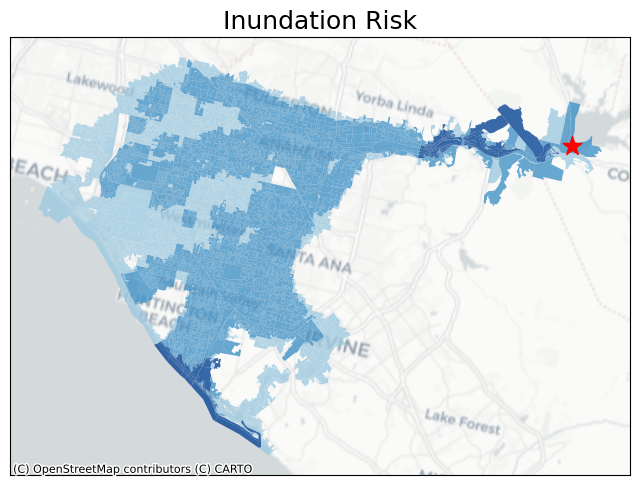

In [10]:
# Plot Inundation Risk
color_brewer = ['#9ecae1','#4292c6','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)

fig, ax = plt.subplots(figsize=(8,8))
lm.plot('Class', ax=ax, cmap=cm, alpha=0.8)
mi_plot = mi.to_crs(epsg=5070)
mi_plot.plot(marker="*", color='red', markersize=200, ax=ax)
# cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, crs=lm.crs, attribution_size=0, zoom=10)
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=fim_geoid_gdf.crs, zoom=10)

ax.set_title('Inundation Risk', fontsize=18)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

/tmp/ipykernel_720216/1171118653.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_gdf = gpd.GeoDataFrame([0], geometry=[lm.unary_union])


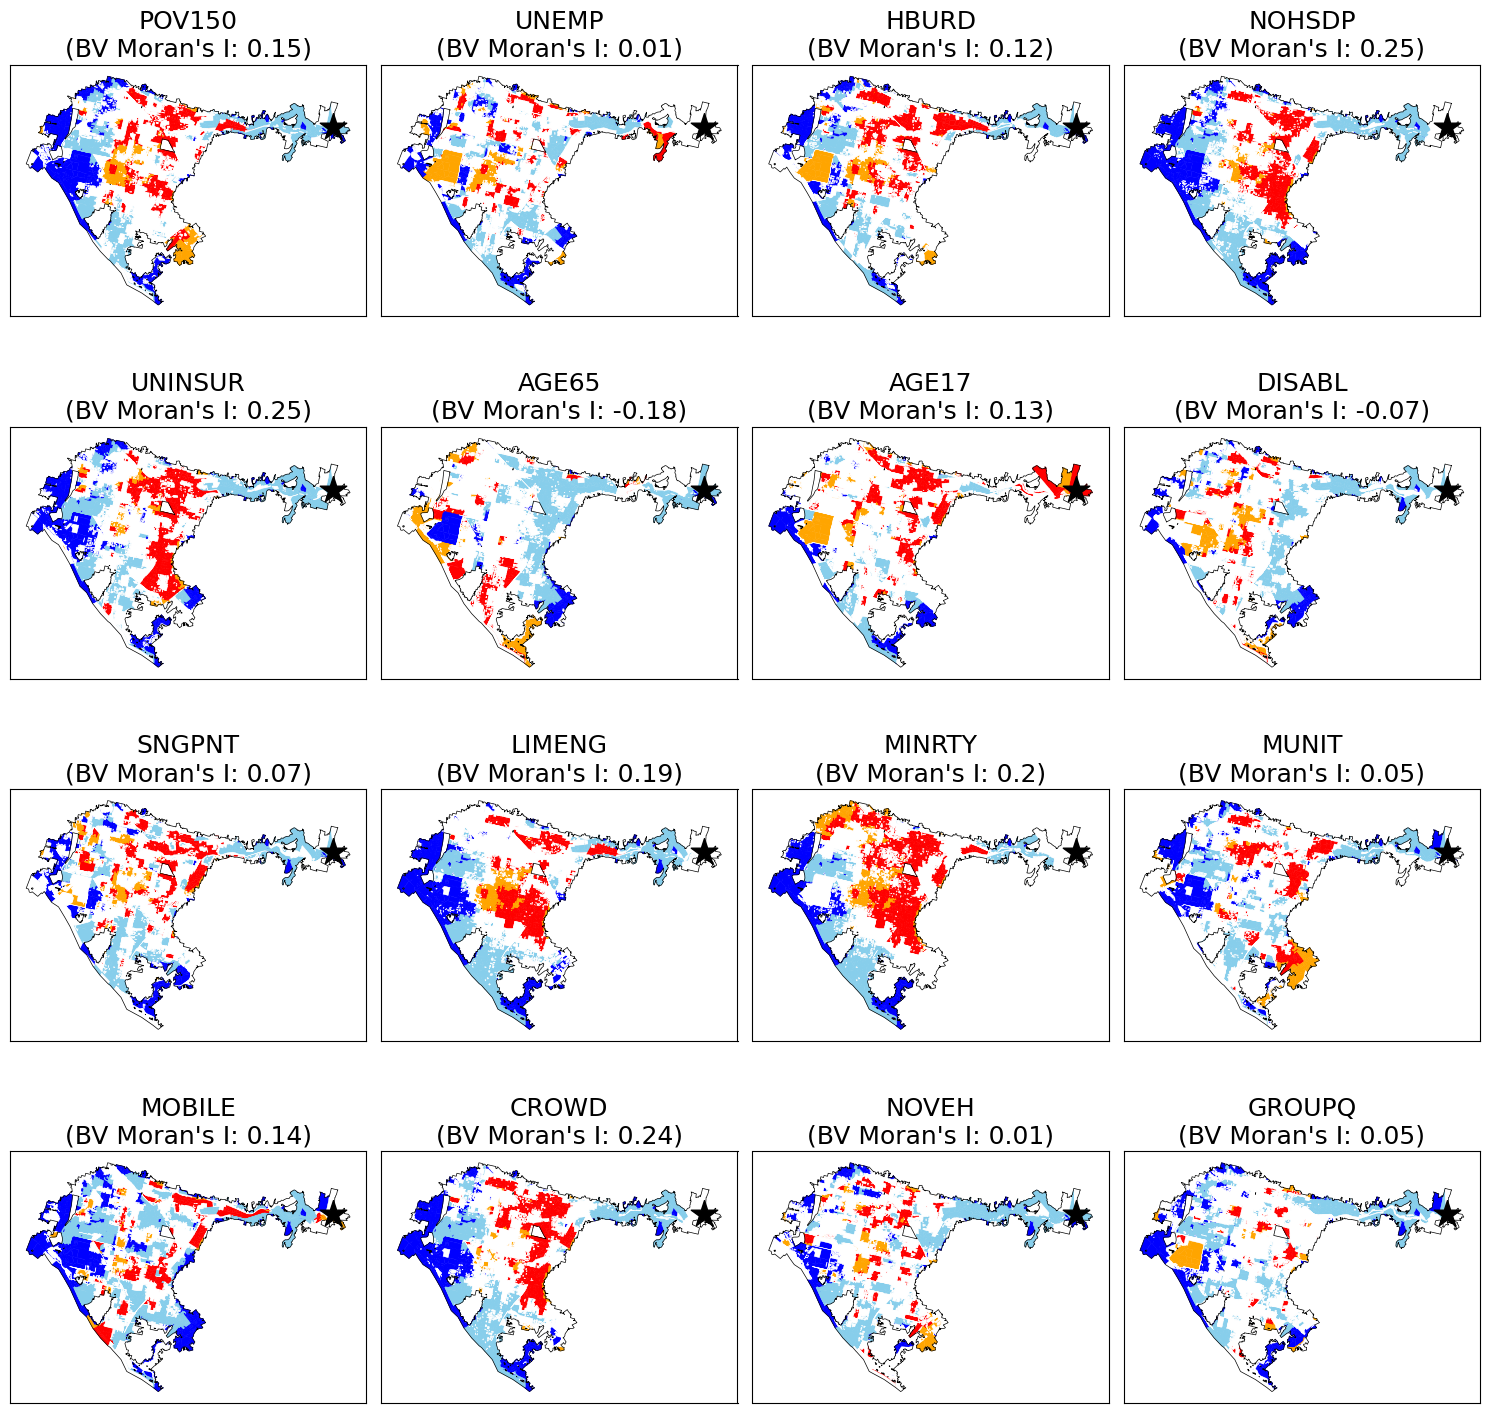

In [11]:
# Plot Bivariate LISA
'''
# The title of each cell provides Bivariate Moran's I 
# Census block color codes:
## Red: HH cluster (high inundation risk and high social vulnerability)
## Skyblue: HL cluster (high inundation risk and low social vulnerability)
## Orange: LH cluster (low inundation risk and high social vulnerability)
## Blue: LL cluster (low inundation risk and low social vulnerability)
'''
plot_cols = [ col.split('_')[1] for col in census_info.keys()]

# LISA
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.reshape(-1)

lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'skyblue', 'LH': 'orange', 'Not_Sig': 'white'}
boundary_gdf = gpd.GeoDataFrame([0], geometry=[lm.unary_union])

for idx, val in enumerate(plot_cols):
    for key in lisa_color.keys():
        lm.loc[(lm[f'LISA_{val}'] == key)].plot(ax=axes[idx], color=lisa_color[key], edgecolor='face', lw=0.3, legend=True)

    boundary_gdf.boundary.plot(ax=axes[idx], lw=0.5, color='black')
    axes[idx].set_title(label=f"{val}\n(BV Moran's I: {round(mi_plot.loc[mi_plot['ID'] == dam_id, f'MI_{val}'].values[0], 2)})",
                        fontsize=18)
    mi_plot.plot(marker="*", color='black', markersize=400, ax=axes[idx])

    axes[idx].get_xaxis().set_visible(False)
    axes[idx].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# Done